In [14]:
"""
@author: pho
"""
%load_ext autoreload
%autoreload 2
import sys
import importlib

import numpy as np
import pandas as pd

## Panel:
import param
import panel as pn
from panel.interact import interact, interactive, fixed, interact_manual
from panel.viewable import Viewer

pn.extension()

## Pho's Custom Libraries:
from pyphocorehelpers.general_helpers import get_arguments_as_optional_dict
from pyphocorehelpers.function_helpers import compose_functions
from pyphocorehelpers.indexing_helpers import partition, build_spanning_bins, compute_spanning_bins, compute_position_grid_size
from pyphocorehelpers.print_helpers import PrettyPrintable, WrappingMessagePrinter
from pyphocorehelpers.geometry_helpers import compute_data_extent, compute_data_aspect_ratio, corner_points_from_extents

from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import * # get_neuron_identities
from pyphoplacecellanalysis.General.SessionSelectionAndFiltering import batch_filter_session
from pyphoplacecellanalysis.General.ComputationResults import ComputationResult
# from PendingNotebookCode import estimation_session_laps


from neuropy.analyses.laps import estimation_session_laps
from neuropy.core.epoch import NamedTimerange

# Neuropy:
from neuropy.analyses.placefields import PlacefieldComputationParameters, perform_compute_placefields
from neuropy.core.neuron_identities import NeuronIdentity, build_units_colormap, PlotStringBrevityModeEnum
from neuropy.utils.debug_helpers import debug_print_placefield, debug_print_spike_counts, debug_print_subsession_neuron_differences

# def estimate_session_laps_load_function(regular_load_function, a_base_dir):
#     session = regular_load_function(a_base_dir)
#     ## Estimate the Session's Laps data using my algorithm from the loaded position data.
#     session = estimation_session_laps(session)
#     return session

known_data_session_type_dict = {'kdiba':KnownDataSessionTypeProperties(load_function=(lambda a_base_dir: DataSessionLoader.kdiba_old_format_session(a_base_dir)),
                               basedir=Path(r'R:\data\KDIBA\gor01\one\2006-6-07_11-26-53')),
                'bapun':KnownDataSessionTypeProperties(load_function=(lambda a_base_dir: DataSessionLoader.bapun_data_session(a_base_dir)),
                               basedir=Path('R:\data\Bapun\Day5TwoNovel'))
               }

known_data_session_type_dict['kdiba'].post_load_functions = [lambda a_loaded_sess: estimation_session_laps(a_loaded_sess)]
# known_data_session_type_dict = {'kdiba':KnownDataSessionTypeProperties(load_function=(lambda a_base_dir: estimation_session_laps(DataSessionLoader.kdiba_old_format_session(a_base_dir))),
#                                basedir=Path(r'R:\data\KDIBA\gor01\one\2006-6-07_11-26-53')),
#                 'bapun':KnownDataSessionTypeProperties(load_function=(lambda a_base_dir: DataSessionLoader.bapun_data_session(a_base_dir)),
#                                basedir=Path('R:\data\Bapun\Day5TwoNovel'))
#                }

# known_data_session_type_dict['kdiba'].name

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Common Setup

In [15]:
def compute_position_grid_bin_size(x, y, num_bins=(64,64), debug_print=False):
    """ Compute Required Bin size given a desired number of bins in each dimension
    Usage:
        active_grid_bin = compute_position_grid_bin_size(curr_kdiba_pipeline.sess.position.x, curr_kdiba_pipeline.sess.position.y, num_bins=(64, 64)
    """
    out_grid_bin_size, out_bins, out_bins_infos = compute_position_grid_size(x, y, num_bins=num_bins)
    active_grid_bin = tuple(out_grid_bin_size)
    if debug_print:
        print(f'active_grid_bin: {active_grid_bin}') # (3.776841861770752, 1.043326930905373)
    return active_grid_bin

In [23]:
# get_arguments_as_optional_dict(subplots=subplots, resolution_multiplier=resolution_multiplier, fignum=fignum, 
#                                         enable_spike_overlay=enable_spike_overlay, spike_overlay_spikes=self.spk_pos,
#                                         drop_below_threshold=drop_below_threshold, brev_mode=brev_mode)


import inspect

fn_spec = inspect.getfullargspec(compute_position_grid_bin_size)
fn_sig = inspect.signature(compute_position_grid_bin_size)

# get_arguments_as_optional_dict(subplots=(10, 8), resolution_multiplier=2.0, fignum=None, enable_spike_overlay=True, drop_below_threshold=0.0000001, brev_mode=PlotStringBrevityModeEnum.CONCISE)

In [29]:
# fn_sig.parameters
fn_spec.args # all kwarg arguments: ['x', 'y', 'num_bins', 'debug_print']

fn_spec.defaults # a tuple of default values corresponding to each argument in args; ((64, 64), False)

((64, 64), False)

# Bapun Format:

In [ ]:
# curr_bapun_pipeline = NeuropyPipeline(name='bapun_pipeline', session_data_type='bapun', basedir=known_data_session_type_dict['bapun'].basedir, load_function=known_data_session_type_dict['bapun'].load_function)
curr_bapun_pipeline = NeuropyPipeline.init_from_known_data_session_type('bapun', known_data_session_type_dict['bapun'])
curr_bapun_pipeline.is_loaded
size_bytes = curr_bapun_pipeline.sess.__sizeof__() # 1753723032
f'object size: {size_bytes/(1024*1024)} MB'

In [ ]:
curr_bapun_pipeline.sess.spikes_df.spikes.time_variable_name # 't_rel_seconds'
curr_bapun_pipeline.sess.position.to_dataframe().position.time_variable_name # t


# .spikes.time_variable_name # 't_rel_seconds'


# spk_df.spikes.time_variable_name

In [ ]:
# Bapun/DataFrame style session filter functions:


def build_bapun_any_maze_epochs_filters(sess):
    def _temp_filter_session_by_epoch1(sess):
        """ 
        Usage:
            active_session, active_epoch = _temp_filter_session(curr_bapun_pipeline.sess)
        """
        active_epoch = sess.epochs.get_named_timerange('maze1')
        ## All Spikes:
        # active_epoch_session = sess.filtered_by_epoch(active_epoch) # old
        active_session = batch_filter_session(sess, sess.position, sess.spikes_df, active_epoch.to_Epoch())
        return active_session, active_epoch

    def _temp_filter_session_by_epoch2(sess):
        """ 
        Usage:
            active_session, active_epoch = _temp_filter_session(curr_bapun_pipeline.sess)
        """
        active_epoch = sess.epochs.get_named_timerange('maze2')
        ## All Spikes:
        # active_epoch_session = sess.filtered_by_epoch(active_epoch) # old
        active_session = batch_filter_session(sess, sess.position, sess.spikes_df, active_epoch.to_Epoch())
        return active_session, active_epoch

    return {'maze1':_temp_filter_session_by_epoch1}
    # return {'maze1':_temp_filter_session_by_epoch1,
    #         'maze2':_temp_filter_session_by_epoch2
    #        }

    # return {'maze1': lambda x: (x.filtered_by_epoch(x.epochs.get_named_timerange('maze1')), x.epochs.get_named_timerange('maze1')),
    #         'maze2': lambda x: (x.filtered_by_epoch(x.epochs.get_named_timerange('maze2')), x.epochs.get_named_timerange('maze2'))
    #        }

active_session_filter_configurations = build_bapun_any_maze_epochs_filters(curr_bapun_pipeline.sess)
curr_bapun_pipeline.filter_sessions(active_session_filter_configurations)
active_grid_bin = compute_position_grid_bin_size(curr_bapun_pipeline.sess.position.x, curr_bapun_pipeline.sess.position.y, num_bins=(64, 64))
active_session_computation_config = PlacefieldComputationParameters(speed_thresh=0.0, grid_bin=active_grid_bin, smooth=(0.5, 0.5), frate_thresh=0.1, time_bin_size=0.25)
curr_bapun_pipeline.perform_computations(active_session_computation_config)
curr_bapun_pipeline.prepare_for_display() # TODO: pass a display config
curr_bapun_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, 'maze1') # works!

In [ ]:
_display_result(curr_bapun_pipeline.computation_results['maze1'])

In [ ]:
_display_result(curr_bapun_pipeline.computation_results['maze2'])

# KDiba Format:

In [3]:
## Data must be pre-processed using the MATLAB script located here: 
# R:\data\KDIBA\gor01\one\IIDataMat_Export_ToPython_2021_11_23.m
# From pre-computed .mat files:
## 07: 
# basedir = r'R:\data\KDIBA\gor01\one\2006-6-07_11-26-53'
# # ## 08:
# basedir = r'R:\data\KDIBA\gor01\one\2006-6-08_14-26-15'
# curr_kdiba_pipeline = NeuropyPipeline(name='kdiba_pipeline', session_data_type='kdiba', basedir=known_data_session_type_dict['kdiba'].basedir, load_function=known_data_session_type_dict['kdiba'].load_function)
curr_kdiba_pipeline = NeuropyPipeline.init_from_known_data_session_type('kdiba', known_data_session_type_dict['kdiba'])

# curr_bapun_pipeline
curr_kdiba_pipeline.is_loaded
size_bytes = curr_kdiba_pipeline.sess.__sizeof__() # 1753723032
f'object size: {size_bytes/(1024*1024)} MB'
# ## Estimate the Session's Laps data using my algorithm from the loaded position data.
# curr_kdiba_pipeline.sess = estimation_session_laps(curr_kdiba_pipeline.sess)
# curr_kdiba_pipeline.sess.epochs

basedir is already Path object.
	 basepath: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53
	 session_name: 2006-6-07_11-26-53
Loading matlab import file results to R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.epochs_info.mat... done.
Loading matlab import file results to R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.position_info.mat... done.
Loading matlab import file results to R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.spikes.mat... done.
Failure loading .position.npy. Must recompute.

Computing linear positions for all active epochs for session... Saving updated position results results to R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.position.npy... 2006-6-07_11-26-53.position.npy saved
done.
	 Failure loading .interpolated_spike_positions.npy. Must recompute.

	 Saving updated interpolated spike position results results to R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.interpolated_spike_positions.npy.

'object size: 144.8962745666504 MB'

In [12]:
def build_any_maze_epochs_filters(sess):
    ## All Spikes:
    sess.epochs.t_start = 22.26 # exclude the first short period where the animal isn't on the maze yet
    active_session_filter_configurations = {'maze1': lambda x: (x.filtered_by_epoch(x.epochs.get_named_timerange('maze1')), x.epochs.get_named_timerange('maze1')),
                                        'maze2': lambda x: (x.filtered_by_epoch(x.epochs.get_named_timerange('maze2')), x.epochs.get_named_timerange('maze2')),
                                        'maze': lambda x: (x.filtered_by_epoch(NamedTimerange(name='maze', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]])), NamedTimerange(name='maze', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]]))
                                       }
    return active_session_filter_configurations

active_session_filter_configurations = build_any_maze_epochs_filters(curr_kdiba_pipeline.sess)
curr_kdiba_pipeline.filter_sessions(active_session_filter_configurations)
active_grid_bin = compute_position_grid_bin_size(curr_kdiba_pipeline.sess.position.x, curr_kdiba_pipeline.sess.position.y, num_bins=(64, 64))
active_session_computation_config = PlacefieldComputationParameters(speed_thresh=2.0, grid_bin=active_grid_bin, smooth=(1.5, 1.5), frate_thresh=0.1, time_bin_size=0.5)
curr_kdiba_pipeline.perform_computations(active_session_computation_config)
curr_kdiba_pipeline.prepare_for_display() # TODO: pass a display config

Applying session filter named "maze1"...
Constraining to epoch with times (start: 22.26, end: 1739.1533641185379)
Applying session filter named "maze2"...
Constraining to epoch with times (start: 1739.1533641185379, end: 1932.4200048116618)
Applying session filter named "maze"...
Constraining to epoch with times (start: 22.26, end: 1932.4200048116618)
Performing single_computation on filtered_session with filter named "maze1"...
Recomputing active_epoch_placefields... 	 done.
Recomputing active_epoch_placefields2D... 	 done.
Performing perform_registered_computations(...) with 1 registered_computation_functions...


c:\users\pho\repos\pyphoplacecellanalysis\src\pyphoplacecellanalysis\Analysis\reconstruction.py:170: RuntimeWarning: divide by zero encountered in double_scalars
  C_tau_n = 1.0 / np.sum(un_normalized_result) # normalize the result
c:\users\pho\repos\pyphoplacecellanalysis\src\pyphoplacecellanalysis\Analysis\reconstruction.py:171: RuntimeWarning: invalid value encountered in multiply
  result = C_tau_n * un_normalized_result
c:\users\pho\repos\pyphoplacecellanalysis\src\pyphoplacecellanalysis\Analysis\reconstruction.py:170: RuntimeWarning: overflow encountered in double_scalars
  C_tau_n = 1.0 / np.sum(un_normalized_result) # normalize the result


Performing single_computation on filtered_session with filter named "maze2"...
Recomputing active_epoch_placefields... 	 done.
Recomputing active_epoch_placefields2D... 	 done.
Performing perform_registered_computations(...) with 1 registered_computation_functions...
Performing single_computation on filtered_session with filter named "maze"...
Recomputing active_epoch_placefields... 	 done.
Recomputing active_epoch_placefields2D... 	 done.
Performing perform_registered_computations(...) with 1 registered_computation_functions...
The specified cmap supports less colors than n_neurons (supports 7, n_neurons: 64). An extended colormap will be built.
The specified cmap supports less colors than n_neurons (supports 7, n_neurons: 64). An extended colormap will be built.
The specified cmap supports less colors than n_neurons (supports 7, n_neurons: 64). An extended colormap will be built.


In [ ]:
def build_lap_epochs_filters(sess):
    lap_specific_epochs = sess.laps.as_epoch_obj()
    any_lap_specific_epochs = lap_specific_epochs.label_slice(lap_specific_epochs.labels[np.arange(len(sess.laps.lap_id))])
    even_lap_specific_epochs = lap_specific_epochs.label_slice(lap_specific_epochs.labels[np.arange(0, len(sess.laps.lap_id), 2)])
    odd_lap_specific_epochs = lap_specific_epochs.label_slice(lap_specific_epochs.labels[np.arange(1, len(sess.laps.lap_id), 2)])
    ## All Spikes:
    sess.epochs.t_start = 22.26 # exclude the first short period where the animal isn't on the maze yet
    active_session_filter_configurations = {'maze1': lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(x.epochs.get_named_timerange('maze1')), x.epochs.get_named_timerange('maze1')),
                                        'maze2': lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(x.epochs.get_named_timerange('maze2')), x.epochs.get_named_timerange('maze2')),
                                        'maze': lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(NamedTimerange(name='maze', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]])), NamedTimerange(name='maze', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]]))
                                       }
    return active_session_filter_configurations

active_session_filter_configurations = build_lap_epochs_filters(curr_kdiba_pipeline.sess)
curr_kdiba_pipeline.filter_sessions(active_session_filter_configurations)
active_grid_bin = compute_position_grid_bin_size(curr_kdiba_pipeline.sess.position.x, curr_kdiba_pipeline.sess.position.y, num_bins=(64, 64))
active_session_computation_config = PlacefieldComputationParameters(speed_thresh=0.0, grid_bin=active_grid_bin, smooth=(0.5, 0.5), frate_thresh=0.1, time_bin_size=0.25)
curr_kdiba_pipeline.perform_computations(active_session_computation_config)
curr_kdiba_pipeline.prepare_for_display() # TODO: pass a display config


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Display import DefaultDisplayFunctions
curr_kdiba_pipeline.prepare_for_display() # TODO: pass a display config
curr_kdiba_pipeline.is_displayed

, **({'should_save_to_disk': False} | kwargs)


data_aspect_ratio: (7.988962073389786, Width_Height_Tuple(width=241.7178791533281, height=30.256480996256016))
Pagination is disabled because one of the subplots values is None. Output will be in a single figure/page.
page_grid_sizes: [RowColTuple(num_rows=22, num_columns=3)]
resolution_multiplier: 1.0, required_figure_size: (24.0, 22.0)
page_idx: 0


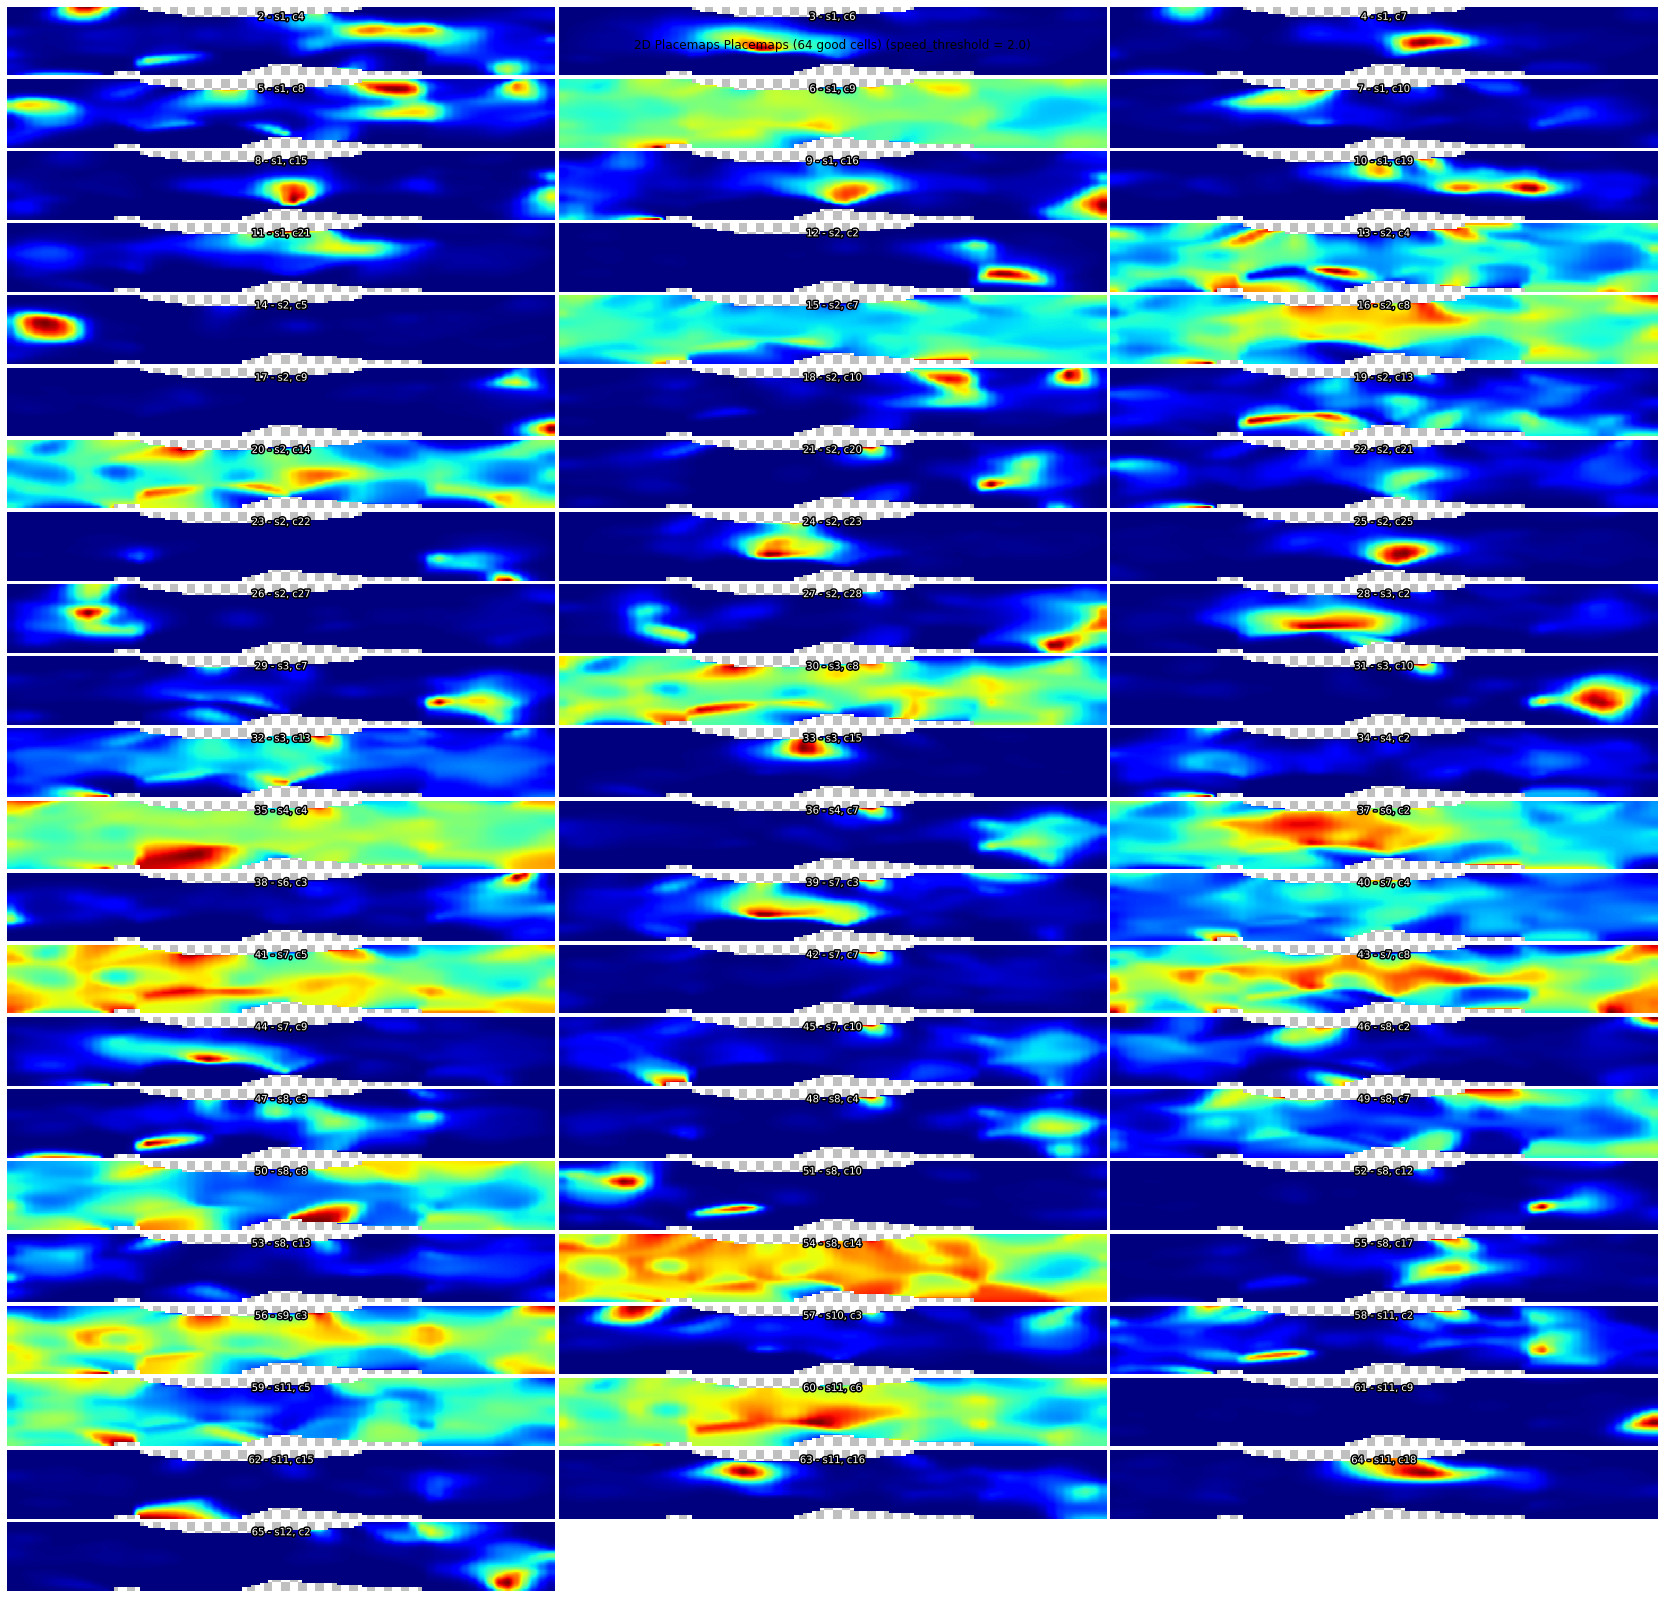

In [13]:
curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, 'maze1') # works!

In [ ]:
# curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_3d_interactive_custom_data_explorer, 'maze1') # works!
curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_3d_interactive_tuning_curves_plotter, 'maze1') # works!

In [ ]:
curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_1d_placefield_validations, 'maze1') # works!

## Position Decoding:

In [ ]:
## Stock Decoder:
from neuropy.analyses.decoders import Decode1d

curr_result_label = 'maze1'
sess = curr_kdiba_pipeline.filtered_sessions[curr_result_label]
pf = curr_kdiba_pipeline.computation_results[curr_result_label].computed_data['pf1D']

def stock_1d_decoder(sess, pf, curr_result_label):
    maze1 = sess.paradigm[curr_result_label]
    # rpls = sess.ripple.time_slice(maze1[0], maze1[1])
    rpls = None
    pf_neurons = sess.neurons.get_by_id(pf.ratemap.neuron_ids) 
    decode = Decode1d(neurons=pf_neurons, ratemap = pf.ratemap, epochs=rpls, bin_size=0.02)
    return decode
    
def validate_stock_1d_decoder(sess, decode):
    # Plot to validate decoder:
    np.shape(decode.decoded_position) # (85845,)
    plt.plot(decode.decoded_position)
    ax = plt.gca()
    # ax.xlim() # (-4292.2, 90136.2)
    ax.set_xlim(10000, 12000)

np.shape(decode.posterior) # (48, 85845)

In [ ]:
##TODO: compute the average speed at each position x:
active_position_df = sess.position.to_dataframe()

pf.config.grid_bin

# xbin, ybin, bin_info = PfND._bin_pos_nD(active_position_df['x'].values, active_position_df['y'].values, bin_size=pf.config.grid_bin) # bin_size mode
# # --- occupancy map calculation -----------
# if (position.ndim > 1):
#     occupancy, xedges, yedges = Pf2D._compute_occupancy(self.x, self.y, xbin, ybin, self.position_srate, smooth)
# else:
#     occupancy, xedges = Pf1D._compute_occupancy(self.x, xbin, self.position_srate, smooth[0])

<!-- % $$\int_{a}^b f(x)dx$$ -->
<!-- Euler's identity: $ e^{i \pi} + 1 = 0 $ -->

## One-step Bayesian Decoder:
$$P(\overrightarrow{x}_{t}|\overrightarrow{n}_{t})$$

$$P(\overrightarrow{n}|\overrightarrow{x})$$ : probability for the numbers of spikes $\overrightarrow{n}$ to occur given we know the animal is at location $\overrightarrow{x}$

## Two-step Bayesian Decoder:
$$P(\overrightarrow{x}_{t}|\overrightarrow{n}_{t}, \overrightarrow{x}_{t-1}) = k P(\overrightarrow{x}_{t}|\overrightarrow{n}_{t}) P(\overrightarrow{x}_{t-1}|\overrightarrow{x}_{t})$$

In [ ]:
import matplotlib.pyplot as plt
%matplotlib qt

curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_plot_most_likely_position_comparisons, 'maze1') # works!

# fig, axs = plot_most_likely_position_comparsions(pho_custom_decoder, sess.position.to_dataframe())


# axs[0].set_xlim(500, 550)
# plt.ioff()

In [ ]:
from neuropy.utils.align_util import align_data
    
active_pos_df = build_position_df_resampled_to_time_windows(sess.position.to_dataframe(), time_bin_size=time_bin_size)
active_pos_df

# active_aligned_pos_df = align_data(pho_custom_decoder.active_time_window_centers, active_pos_df['t'].to_numpy(), active_pos_df[['x','y']].to_numpy())
active_aligned_pos_df = align_data(pho_custom_decoder.active_time_window_centers, active_pos_df.index, active_pos_df['x'])
active_aligned_pos_df

In [ ]:
# from pyphoplacecellanalysis.General.Decoder.decoder_result import DecoderResultDisplayingPlot2D
# def _display_decoder_result():
#     renderer = DecoderResultDisplayingPlot2D(pho_custom_decoder, active_pos_df)
#     def animate(i):
#         # print(f'animate({i})')
#         return renderer.display(i)
#     interact(animate, i=(0, pho_custom_decoder.num_time_windows, 10))

curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_decoder_result, 'maze1') # works!

In [ ]:
# @pn.interact(i=(0,pho_custom_decoder.num_time_windows,1,0))
# @interact(i=pn.widgets.IntSlider(start=0,end=pho_custom_decoder.num_time_windows,step=1,value=0))

# ani = FuncAnimation(renderer.fig, animate, interval=300)
# interact(animate, i=(0, pho_custom_decoder.num_time_windows, 10))

# pn.Column('**A custom interact layout**', pn.Row(layout[0], layout[1]))

In [ ]:
def debug_plot_filtered_subsession_neuron_differences(sess, filtered_sess):
    print_subsession_neuron_differences(sess.neurons, active_epoch_session.neurons)

[debug_plot_filtered_subsession_neuron_differences(curr_kdiba_pipeline.sess, a_filtered_sess) for a_filtered_sess in curr_kdiba_pipeline.filtered_sessions]

In [ ]:
curr_kdiba_pipeline.computation_results['maze2']

In [ ]:
_display_result(curr_kdiba_pipeline.computation_results['maze1'])
_display_result(curr_kdiba_pipeline.computation_results['maze2'])

In [ ]:
def _display_normal(computation_result, active_config):
    """ 
    Usage: _display_normal(curr_kdiba_pipeline.computation_results['maze1'], curr_kdiba_pipeline.active_configs['maze1'])
    """
    from neuropy.plotting.placemaps import plot_all_placefields
    # from neuropy.core.neuron_identities import build_units_colormap
    # print(f'active_config: {active_config}')
    # active_config = computation_result.sess.config
    if active_config.computation_config is None:
        active_config.computation_config = computation_result.computation_config

    pf_neuron_identities, pf_sort_ind, pf_colors, pf_colormap, pf_listed_colormap = get_neuron_identities(computation_result.computed_data['pf2D'])
    ax_pf_1D, occupancy_fig, active_pf_2D_figures, active_pf_2D_gs = plot_all_placefields(computation_result.computed_data['pf1D'], computation_result.computed_data['pf2D'], active_config, should_save_to_disk=False)
    
# curr_kdiba_pipeline.computation_results['maze1'].computation_config
# curr_kdiba_pipeline.computation_results['maze1'].sess.config
# curr_kdiba_pipeline.active_configs['maze1']
_display_normal(curr_kdiba_pipeline.computation_results['maze1'], curr_kdiba_pipeline.active_configs['maze1'])

# _display_normal

In [ ]:
import matplotlib.pyplot as plt
from neuropy.utils.misc import is_iterable
from neuropy.plotting.figure import pretty_plot
from scipy.ndimage import gaussian_filter, gaussian_filter1d, interpolation

from pyphoplacecellanalysis.Analysis.reliability import compute_lap_to_lap_reliability

from PhoPositionalData.plotting.laps import plot_laps_2d


def _test_plotRaw_v_time(active_pf, cellind, speed_thresh=False, alpha=0.5, ax=None):
        """ Builds one subplot for each dimension of the position data
        
        Updated to work with both 1D and 2D Placefields """   
        if ax is None:
            fig, ax = plt.subplots(active_pf.ndim, 1, sharex=True)
            fig.set_size_inches([23, 9.7])
        
        if not is_iterable(ax):
            ax = [ax]
            
        # plot trajectories
        if active_pf.ndim < 2:
            variable_array = [active_pf.x]
            label_array = ["X position (cm)"]
        else:
            variable_array = [active_pf.x, active_pf.y]
            label_array = ["X position (cm)", "Y position (cm)"]
            
        for a, pos, ylabel in zip(ax, variable_array, label_array):
            a.plot(active_pf.t, pos)
            a.set_xlabel("Time (seconds)")
            a.set_ylabel(ylabel)
            pretty_plot(a)

        # Grab correct spike times/positions
        if speed_thresh:
            spk_pos_, spk_t_ = active_pf.run_spk_pos, active_pf.run_spk_t
        else:
            spk_pos_, spk_t_ = active_pf.spk_pos, active_pf.spk_t

        # plot spikes on trajectory
        for a, pos in zip(ax, spk_pos_[cellind]):
            a.plot(spk_t_[cellind], pos, ".", color=[0, 0, 0.8, alpha])

        # Put info on title
        ax[0].set_title(
            "Cell "
            + str(active_pf.cell_ids[cellind])
            + ":, speed_thresh="
            + str(active_pf.speed_thresh)
        )
        return ax


def compute_reliability_metrics(out_indicies, out_digitized_position_bins, out_within_lap_spikes_overlap, debug_print=False, plot_results=False):
    """ Takes input from compute_lap_to_lap_reliability(...) to build the actual reliability metrics """
    # Actual Computations of Reliability:
    out_pairwise_pair_results = np.zeros_like(out_within_lap_spikes_overlap)
    
    # do simple diff:
    laps_spikes_overlap_diff = np.diff(out_within_lap_spikes_overlap, axis=1) # the element-wise diff of the overlap. Shows changes.
    out_pairwise_pair_results[:, 1:] = laps_spikes_overlap_diff
    # out_pairwise_pair_results[:, -1] = np.zeros_like(out_within_lap_spikes_overlap[:,0])
    
    # do custom pairwise operation:
#     for first_item_lap_idx, next_item_lap_idx in list(out_pairwise_flat_lap_indicies):
#         first_item = out_within_lap_spikes_overlap[:, first_item_lap_idx]
#         next_item = out_within_lap_spikes_overlap[:, next_item_lap_idx]
#         out_pairwise_pair_results[:, next_item_lap_idx] = (first_item * next_item) # the result should be stored in the index of the second item, if we're doing the typical backwards style differences.
#         # print(f'np.max(out_pairwise_pair_results[:, next_item_lap_idx]): {np.max(out_pairwise_pair_results[:, next_item_lap_idx])}')

    if debug_print: 
        print(f'max out: {np.max(out_pairwise_pair_results)}')
        
    lap_ids 
    flat_lap_idxs = np.arange(len(lap_ids))
    
    
    # add to the extant plot as a new color:
    if plot_results:
        for lap_idx, lap_ID in zip(flat_lap_idxs, lap_ids):
            # curr_lap_alt_ax = axs[lap_idx]
            if plot_horizontal:
                curr_lap_alt_ax = axs[lap_idx].twiny()
                curr_lap_alt_ax.plot(out_pairwise_pair_results[:, lap_idx], out_digitized_position_bins, '--r')
            else:
                # vertical
                curr_lap_alt_ax = axs[lap_idx].twinx()
                curr_lap_alt_ax.plot(out_digitized_position_bins, out_pairwise_pair_results[:, lap_idx], '--r')
            
    cum_laps_reliability = np.cumprod(out_within_lap_spikes_overlap, axis=1)
    all_laps_reliability = np.prod(out_within_lap_spikes_overlap, axis=1, keepdims=True)
    
    if plot_results:
        fig_result, axs_result = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(24, 40))
        axs_result[0].plot(out_digitized_position_bins, all_laps_reliability, 'r')
        axs_result[1].plot(out_digitized_position_bins, cum_laps_reliability, 'r')

curr_result_label = 'maze1'
sess = curr_kdiba_pipeline.filtered_sessions[curr_result_label]
sess = curr_kdiba_pipeline.sess

In [ ]:
curr_laps_df = sess.laps.to_dataframe()
curr_laps_df

In [ ]:
pos_df = sess.compute_position_laps() # ensures the laps are computed if they need to be:
position_obj = sess.position
position_obj.compute_higher_order_derivatives()
pos_df = position_obj.compute_smoothed_position_info(N=20) ## Smooth the velocity curve to apply meaningful logic to it
pos_df = position_obj.to_dataframe()
pos_df

In [ ]:
# fig, out_axes_list = plot_laps_2d(sess, legacy_plotting_mode=True)
fig, out_axes_list = plot_laps_2d(sess, legacy_plotting_mode=False)
out_axes_list[0].set_title('New Pho Position Thresholding Estimated Laps')

curr_cell_idx = 2 
# curr_cell_idx = 3 # good for end platform analysis
curr_cell_ID = sess.spikes_df.spikes.neuron_ids[curr_cell_idx]
print(f'curr_cell_idx: {curr_cell_idx}, curr_cell_ID: {curr_cell_ID}')

# pre-filter by spikes that occur in one of the included laps for the filtered_spikes_df
filtered_spikes_df = sess.spikes_df.copy()
time_variable_name = filtered_spikes_df.spikes.time_variable_name # 't_rel_seconds'

lap_ids = sess.laps.lap_id
# lap_flat_idxs = sess.laps.get_lap_flat_indicies(lap_ids)

out_indicies, out_digitized_position_bins, out_within_lap_spikes_overlap = compute_lap_to_lap_reliability(curr_kdiba_pipeline.computation_results[curr_result_label].computed_data['pf2D'], filtered_spikes_df, lap_ids, curr_cell_idx, debug_print=False, plot_results=True);

# compute_reliability_metrics(out_indicies, out_digitized_position_bins, out_within_lap_spikes_overlap, debug_print=False, plot_results=False)

# # curr_kdiba_pipeline.computation_results['maze1'].computed_data['pf2D'].plotRaw_v_time(curr_cell_idx)
# _test_plotRaw_v_time(curr_kdiba_pipeline.computation_results[curr_result_label].computed_data['pf2D'], curr_cell_idx)

# 3D Lap Plotting Experimentation

In [ ]:
from itertools import islice # for Pagination class
import pyvista as pv
import pyvistaqt as pvqt
from PhoGui.InteractivePlotter.LapsVisualizationMixin import LapsVisualizationMixin
from PhoGui.PhoCustomVtkWidgets import PhoWidgetHelper
from PhoPositionalData.plotting.spikeAndPositions import perform_plot_flat_arena, _build_flat_arena_data

""" Test Drawing Spike Lines """
# from pyphoplacecellanalysis.Pho3D.spikes import draw_line_spike, lines_from_points
from pyphoplacecellanalysis.Pho3D.points import interlieve_points

from PhoPositionalData.plotting.spikeAndPositions import build_active_spikes_plot_pointdata_df

def _plot_all_lap_spikes(p, sess, included_cell_IDXs, included_lap_IDXs, debug_print=True, lap_start_z=0.0, lap_id_dependent_z_offset=10.0):
    should_reinterpolate_spike_positions = False
        
    def _plot_single_spikes(p, cell_specific_spikes_dfs, placefield_cell_index):
        curr_cell_spike_df = cell_specific_spikes_dfs[placefield_cell_index]
        # curr_cell_spike_df['z_fixed'] = np.full_like(active_flat_df['x'].values, 1.1)
        pdata = build_active_spikes_plot_pointdata_df(curr_cell_spike_df)

        # curr_cell_spike_times = curr_cell_spike_df[curr_cell_spike_df.spikes.time_variable_name].to_numpy()  # (271,)
        # curr_cell_spike_positions = curr_cell_spike_df['x','y'].to_numpy()  # (271,)

        # lines_from_points(
        # p[0,0].add_points(pdata, name='plot_single_spikes_points', render_points_as_spheres=True, point_size=5.0)

        # Build offset points and spike data:
        spike_height = max((lap_id_dependent_z_offset * 0.6), 0.5) # half the line height

        # start_points = pdata.points.copy()
        # end_points = start_points.copy()
        # # end_points[:,2] # get z values
        # end_points[:,2] = end_points[:,2] + spike_height
        # all_points = interlieve_points(start_points, end_points)
        # lines_poly_data = pv.PolyData()
        # lines_poly_data.points = all_points
        # # cells = np.hstack(([2, 0, 1],[2, 1, 2]))
        # num_lines = np.shape(start_points)[0]
        # cells = [[2, 2*i, 2*i+1] for i in np.arange(num_lines)]
        # lines_poly_data.lines = cells
        
        p[0,0].add_mesh(pdata, name=f'plot_single_spikes_points[{placefield_cell_index}]', render_points_as_spheres=True, point_size=5.0, color='white')        
        
        # p[0,0].add_points(pdata, name=f'plot_single_spikes_points[{placefield_cell_index}]', render_points_as_spheres=True, point_size=5.0)
        # p[0,0].add_mesh(lines_poly_data, name=f'plot_single_spikes_lines[{placefield_cell_index}]', render_points_as_spheres=False, point_size=5.0)
        # return {'pdata':pdata, 'lines_poly_data':lines_poly_data}
        
        return {'pdata':pdata}
    
    time_variable_name = sess.spikes_df.spikes.time_variable_name # 't_rel_seconds'
    # sets the 'z_fixed' value for all spikes in sess.spikes_df, which will be used to plot them as points
    sess.spikes_df['z'] = lap_start_z + (lap_id_dependent_z_offset * sess.spikes_df.lap.to_numpy())

    if debug_print:
        print(f'sess.laps.lap_id: {sess.laps.lap_id}')
        
    included_cell_IDXs = np.array(included_cell_IDXs)
    included_lap_IDXs = np.array(included_lap_IDXs)
    
    # ensure that only lap_ids included in this session are used:
    included_lap_ids = sess.laps.lap_id[included_lap_IDXs]
    possible_included_lap_ids = np.unique(sess.spikes_df.lap.values)
    if debug_print:
        print(f'np.unique(sess.spikes_df.lap.values): {np.unique(sess.spikes_df.lap.values)}')
    included_lap_ids = included_lap_ids[np.isin(included_lap_ids, possible_included_lap_ids)]
    if debug_print:
        print(f'included_lap_ids: {included_lap_ids}')
    
    # get the included cell IDs
    included_cell_IDs = np.array(sess.spikes_df.spikes.neuron_ids)[included_cell_IDXs]
        
    # print(np.isin(['R','G','B','render_opacity'], sess.spikes_df.columns).all())

    # POSITIONS:
    curr_position_df, lap_specific_position_dfs, lap_specific_time_ranges, lap_specific_position_traces = LapsVisualizationMixin._compute_laps_position_data(sess)
    
    # SPIKES:
    # # grouped by lap
    # lap_grouped_spikes_df = sess.spikes_df.groupby('lap')
    # lap_specific_spikes_dfs = [lap_grouped_spikes_df.get_group(i)[[time_variable_name,'aclu','lap','flat_spike_idx','cell_type','x','y','lin_pos','z']] for i in included_lap_ids] # dataframes split for each ID:

    # grouped by cell:
    # pre-filter by spikes that occur in one of the included laps for the filtered_spikes_df
    filtered_spikes_df = sess.spikes_df.copy()
    filtered_spikes_df = filtered_spikes_df[np.isin(filtered_spikes_df['lap'], included_lap_ids)] # get only the spikes that occur in one of the included laps for the filtered_spikes_df
    
    
    # Interpolate the spikes positions again:
    if should_reinterpolate_spike_positions:
        print('Re-interpolating spike positions...')
        filtered_spikes_df = filtered_spikes_df.spikes.interpolate_spike_positions(curr_position_df['t'].to_numpy(), curr_position_df['x'].to_numpy(), curr_position_df['y'].to_numpy())
        # filtered_spikes_df = FlattenedSpiketrains.interpolate_spike_positions(filtered_spikes_df, session.position.time, session.position.x, session.position.y, spike_timestamp_column_name=time_variable_name)
    
    cell_grouped_spikes_df = filtered_spikes_df.groupby('aclu')
    cell_specific_spikes_dfs = [cell_grouped_spikes_df.get_group(i)[[time_variable_name,'aclu','lap','flat_spike_idx','cell_type','x','y','lin_pos','z']] for i in included_cell_IDs] # dataframes split for each ID:

    # lap_specific_position_dfs = _compute_laps_position_data(sess)

    # # Positions:
    # curr_position_df = sess.compute_position_laps()
    # included_pos_lap_ids = np.unique(curr_position_df.lap.values)
    # print(f'np.unique(curr_position_df.lap.values): {np.unique(curr_position_df.lap.values)}')
    # included_pos_lap_ids = included_pos_lap_ids[np.isin(included_pos_lap_ids, sess.laps.lap_id)]
    # included_pos_lap_ids

    # print(f'included_pos_lap_ids: {included_pos_lap_ids}')

    # lap_grouped_position_df = curr_position_df.groupby('lap')
    # lap_specific_position_dfs = [lap_grouped_position_df.get_group(i)[['t','aclu','x','y','lin_pos']] for i in included_lap_ids] # dataframes split for each ID:

    for i, curr_cell_ID in enumerate(included_cell_IDs):
        plot_data_dict = _plot_single_spikes(p, cell_specific_spikes_dfs, i)


# sess = curr_kdiba_pipeline.filtered_sessions['maze']
# included_cell_IDXs = [6]
# included_lap_IDXs = [2, 3]
# _plot_all_lap_spikes(pActiveInteractiveLapsPlotter, sess, included_cell_IDXs, included_lap_IDXs)

from PhoGui.InteractivePlotter.InteractiveCustomDataExplorer import InteractiveCustomDataExplorer

lap_start_z = 0.0
# lap_id_dependent_z_offset = 0.0
lap_id_dependent_z_offset = 3.0
# curr_kdiba_pipeline.active_configs['maze1'].lap_id_dependent_z_offset = 3.0

def _display_testing(sess, computation_result, active_config, extant_plotter=None):
    """ Testing of plot_lap_trajectories_2d """
    print(f'active_config.plotting_config: {active_config.plotting_config}')
    single_combined_plot=True
    if single_combined_plot:
        default_plotting = True
    else:
        default_plotting = False
    active_config.plotting_config.plotter_type = 'MultiPlotter'
    print(f'active_config.plotting_config: {active_config.plotting_config}')
    iplapsDataExplorer = InteractiveCustomDataExplorer(active_config, sess, extant_plotter=extant_plotter)
    pActiveInteractiveLapsPlotter = iplapsDataExplorer.plot(pActivePlotter=extant_plotter, default_plotting=default_plotting)
    # included_cell_idxs = None
    included_cell_idxs = [0, 1]
    # included_lap_idxs = [2, 5, 9, 12]
    included_lap_idxs = [2]
    # All
    # included_cell_idxs = np.arange(len(sess.spikes_df.spikes.neuron_ids))
    # included_lap_idxs = np.arange(len(sess.laps.lap_id))
    from PhoPositionalData.plotting.laps import plot_lap_trajectories_3d
    pActiveInteractiveLapsPlotter, laps_pages = plot_lap_trajectories_3d(sess, curr_num_subplots=5, active_page_index=0, included_lap_idxs=included_lap_idxs, single_combined_plot=single_combined_plot, 
                                                                         lap_start_z = lap_start_z, lap_id_dependent_z_offset = lap_id_dependent_z_offset,
                                                                         existing_plotter=pActiveInteractiveLapsPlotter)

    # add the spikes for the curves:
    _plot_all_lap_spikes(pActiveInteractiveLapsPlotter, sess, included_cell_idxs, included_lap_idxs, lap_start_z=lap_start_z, lap_id_dependent_z_offset=lap_id_dependent_z_offset)
    return iplapsDataExplorer, pActiveInteractiveLapsPlotter


# curr_kdiba_pipeline.computation_results['maze1'].computation_config
# curr_kdiba_pipeline.computation_results['maze1'].sess.config
# curr_kdiba_pipeline.active_configs['maze1']

curr_result_label = 'maze1'
sess = curr_kdiba_pipeline.filtered_sessions[curr_result_label]
sess = curr_kdiba_pipeline.sess

pActiveInteractiveLapsPlotter = None
try: pActiveInteractiveLapsPlotter
except NameError: pActiveInteractiveLapsPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
iplapsDataExplorer, pActiveInteractiveLapsPlotter = _display_testing(sess, curr_kdiba_pipeline.computation_results[curr_result_label], curr_kdiba_pipeline.active_configs[curr_result_label],
                                                                     extant_plotter=pActiveInteractiveLapsPlotter)
pActiveInteractiveLapsPlotter.show()

In [ ]:
# lines_from_points(pdata.points)


np.shape(all_points)

In [ ]:
p, laps_pages = _plot_lap_trajectories_combined_plot_3d(curr_kdiba_pipeline.sess, curr_num_subplots=5, single_combined_plot=False)
p.show()